# Simple Toy TS Training for Deep3D+

In [1]:
"""
Simple tester for the deep3d
"""
import tensorflow as tf
import Deep3D_branched as deep3d
import utils
import numpy as np
import os
import os.path
import h5py

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Importing Data from H5 Format for fast loading
- Will eventually unit test dynamic CPU data loading pipeline here

In [2]:
inria_file = '/a/data/deep3d_data/inria_data.h5'
# inria_file = 'data/inria_data.h5'
h5f = h5py.File(inria_file,'r')

X_train_0 = h5f['X_0'][:,10:170,16:304,:]
Y_train_0 = h5f['Y_0'][:,10:170,16:304,:]
X_train_1 = h5f['X_1'][:,10:170,16:304,:]
Y_train_1 = h5f['Y_1'][:,10:170,16:304,:]
X_train_2 = h5f['X_2'][:,10:170,16:304,:]
Y_train_2 = h5f['Y_2'][:,10:170,16:304,:]
X_train_3 = h5f['X_3'][:,10:170,16:304,:]
Y_train_3 = h5f['Y_3'][:,10:170,16:304,:]
X_train_4 = h5f['X_4'][:,10:170,16:304,:]
Y_train_4 = h5f['Y_4'][:,10:170,16:304,:]
X_train_5 = h5f['X_5'][:,10:170,16:304,:]
Y_train_5 = h5f['Y_5'][:,10:170,16:304,:]
X_train_6 = h5f['X_6'][:,10:170,16:304,:]
Y_train_6 = h5f['Y_6'][:,10:170,16:304,:]
#X_train_7 = h5f['X_7'][:,10:170,16:304,:]
#Y_train_7 = h5f['Y_7'][:,10:170,16:304,:]


X_val = h5f['X_7'][:,10:170,16:304,:]
Y_val = h5f['Y_7'][:,10:170,16:304,:]
  
h5f.close()



# ------------------------------------------#
X_train = np.concatenate([X_train_0,X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6])
Y_train = np.concatenate([Y_train_0,Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5,Y_train_6])

print "Training Size:" + str(X_train.shape)
print "Validation Size:" + str(X_val.shape)

Training Size:(3500, 160, 288, 3)
Validation Size:(443, 160, 288, 3)


## Training Loop

In [3]:
batchsize = 32
num_epochs = 3
num_batches = (X_train.shape[0]/batchsize)*num_epochs
print_step = 1
viz_step = 10

# Define config for GPU memory debugging 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # Switch to True for dynamic memory allocation instead of TF hogging BS
config.gpu_options.per_process_gpu_memory_fraction= 1  # Cap TF mem usage
config.allow_soft_placement=True
with tf.device('/gpu:0'):
    # Session
    sess = tf.Session(config=config)
    
    # Placeholders
    images = tf.placeholder(tf.float32, [None, 160, 288, 3], name='input_batch')
    true_out = tf.placeholder(tf.float32, [None, 160, 288, 3] , name='ground_truth')
    train_mode = tf.placeholder(tf.bool, name='train_mode')

    # Building Net based on VGG weights 
    net = deep3d.Deep3Dnet('./vgg19.npy', dropout = 0.5)
    net.build(images, train_mode)

    # Print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print 'Variable count:'
    print(net.get_var_count())
    
    # Run initializer 
    sess.run(tf.global_variables_initializer())
   
    # Define Training Objectives
    with tf.variable_scope("Loss"):
        cost = (tf.reduce_sum(tf.abs(net.prob - true_out))*255)/(batchsize*160*288)
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):    
        train = tf.train.GradientDescentOptimizer(0.002).minimize(cost)
        
    # Track Cost    
    tf.summary.scalar('cost', cost)
    # tensorboard operations to compile summary and then write into logs
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./tensorboard_logs/', graph = sess.graph)

    
    # Training Loop
    print ""
    print "== Start training =="
    for i in xrange(num_batches):
        # Creating Batch
        image_mask = np.random.choice(X_train.shape[0],batchsize)
        images_in = X_train[image_mask,:,:,:]
        labels_in = Y_train[image_mask,:,:,:]

        # Traing Step
        _, cost_val, summary = sess.run([train, cost, merged], feed_dict={images: images_in, true_out: labels_in, train_mode: True})
        writer.add_summary(summary, i)

        # No longer needed: cost_hist.append(cost_val)
        if i%print_step == 0:
            print ("({}/{})".format(i, num_batches).ljust(10) + ' | Cost: ' + str(cost_val))
    
    
    print ""
    print "Training Completed, storing weights"
    # Store Traing Output
    net.save_npy(sess)
    

Variable count:
139063583

== Start training ==
(0/327)    | Cost: 70.6783
(1/327)    | Cost: 41.5871
(2/327)    | Cost: 47.2737
(3/327)    | Cost: 41.3815
(4/327)    | Cost: 39.5985
(5/327)    | Cost: 30.8675
(6/327)    | Cost: 42.2674
(7/327)    | Cost: 37.4667
(8/327)    | Cost: 39.4721
(9/327)    | Cost: 42.2469
(10/327)   | Cost: 42.3379
(11/327)   | Cost: 44.4903
(12/327)   | Cost: 43.7175
(13/327)   | Cost: 41.5843
(14/327)   | Cost: 42.9588
(15/327)   | Cost: 37.9542
(16/327)   | Cost: 40.4111
(17/327)   | Cost: 39.2458
(18/327)   | Cost: 39.3097
(19/327)   | Cost: 41.8634
(20/327)   | Cost: 39.6237
(21/327)   | Cost: 38.9651
(22/327)   | Cost: 34.5075
(23/327)   | Cost: 40.0534
(24/327)   | Cost: 43.454
(25/327)   | Cost: 38.5459
(26/327)   | Cost: 41.2503
(27/327)   | Cost: 45.0648
(28/327)   | Cost: 39.2836
(29/327)   | Cost: 45.0593
(30/327)   | Cost: 46.6806
(31/327)   | Cost: 42.6902
(32/327)   | Cost: 47.3848
(33/327)   | Cost: 36.8921
(34/327)   | Cost: 41.903
(35/327) 

(303/327)  | Cost: 36.4605
(304/327)  | Cost: 37.3109
(305/327)  | Cost: 43.2742
(306/327)  | Cost: 40.2869
(307/327)  | Cost: 40.5255
(308/327)  | Cost: 45.0704
(309/327)  | Cost: 46.8464
(310/327)  | Cost: 43.1124
(311/327)  | Cost: 35.7998
(312/327)  | Cost: 41.8419
(313/327)  | Cost: 51.1799
(314/327)  | Cost: 51.1463
(315/327)  | Cost: 43.4154
(316/327)  | Cost: 46.7812
(317/327)  | Cost: 44.963
(318/327)  | Cost: 46.5145
(319/327)  | Cost: 41.0862
(320/327)  | Cost: 44.4548
(321/327)  | Cost: 46.1124
(322/327)  | Cost: 48.1605
(323/327)  | Cost: 42.4835
(324/327)  | Cost: 37.798
(325/327)  | Cost: 37.9418
(326/327)  | Cost: 38.9972

Training Completed, storing weights
('file saved', './deep3d-save.npy')


## Testing Output

In [34]:
# Test
test_img = np.expand_dims(X_val[170], axis = 0)
test_ans = Y_val[170]

with tf.device("/gpu:0"):
    res, mask, up_conv = sess.run([net.prob, net.mask, net.up_conv], 
                                  feed_dict={images: test_img, train_mode: False})

--- Input ---


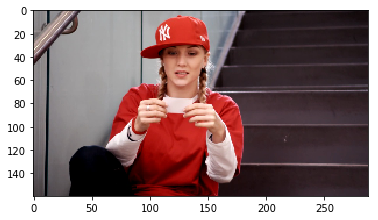

--- GT ---


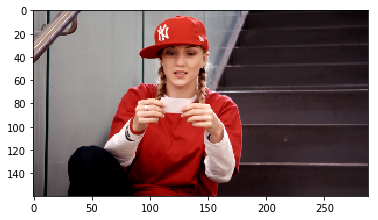

--- Our result ---


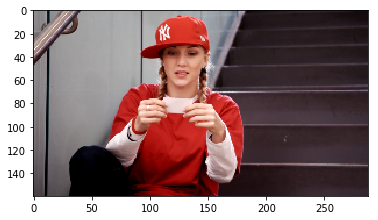

In [35]:
import matplotlib.pyplot as plt
print "--- Input ---"
plt.imshow(test_img[0])
plt.show()

print "--- GT ---"
plt.imshow(test_ans)
plt.show()

print "--- Our result ---"
plt.imshow(res[0])
plt.show()

#pyplot.imsave('1.jpeg', test_img[0])
#pyplot.imsave('2.jpeg', res[0])

## Looking at Disparity Maps

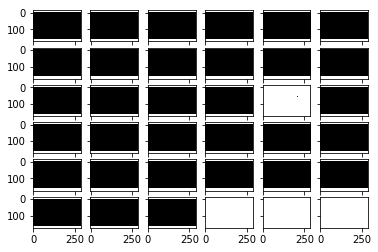

In [36]:
f, axs = plt.subplots(6, 6, sharex='col', sharey='row')

for i in range(33):
    axs[i/6][i%6].imshow(mask[0,:,:,i],cmap="gray",vmin=0.0, vmax=1.0)
plt.show()

In [37]:
max_shift_channel = np.argmax(mask,axis = 3)
max_shift_channel[0]

array([[16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       ..., 
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16]])

In [38]:
channel_mean = np.mean(mask[0], axis =(0,1))
channel_mean

array([  3.10766954e-05,   3.08903145e-05,   3.08116578e-05,
         3.08116469e-05,   3.08116469e-05,   3.13524142e-05,
         3.09538227e-05,   3.08247436e-05,   3.08501767e-05,
         3.10647411e-05,   3.09086972e-05,   3.44562504e-05,
         3.08574890e-05,   3.29584109e-05,   3.08417693e-05,
         3.42803687e-05,   9.98990536e-01,   3.17339000e-05,
         3.48571484e-05,   3.16005135e-05,   3.13885685e-05,
         3.18899693e-05,   3.14203280e-05,   3.36336561e-05,
         3.15768812e-05,   3.08313793e-05,   3.09545467e-05,
         3.13981400e-05,   3.08824274e-05,   3.09577445e-05,
         3.08695562e-05,   3.08116469e-05,   3.09150419e-05], dtype=float32)

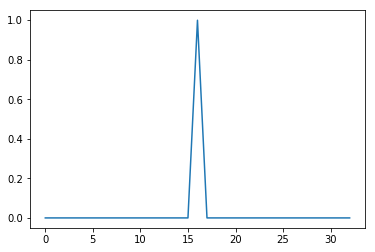

In [39]:
plt.plot(channel_mean)
plt.show()

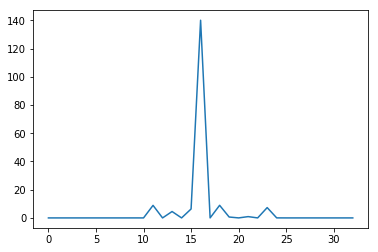

In [40]:
channel_act_mean = np.mean(up_conv[0], axis =(0,1))
plt.plot(channel_act_mean)
plt.show()

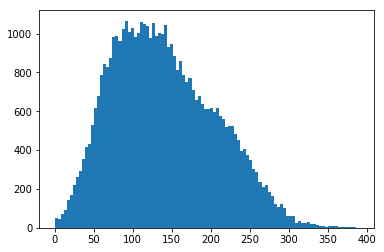

In [41]:
plt.hist(up_conv[0,:,:,16].ravel(), bins=100)
plt.show()

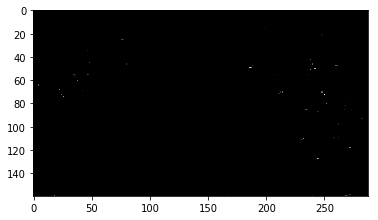

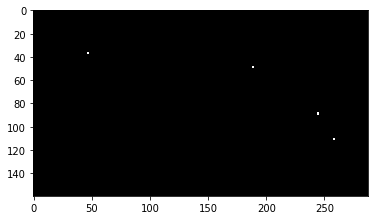

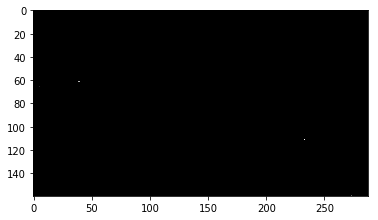

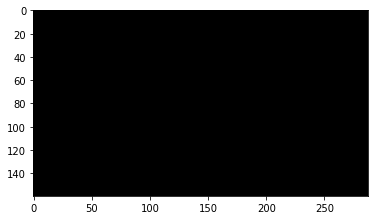

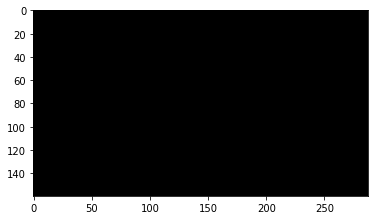

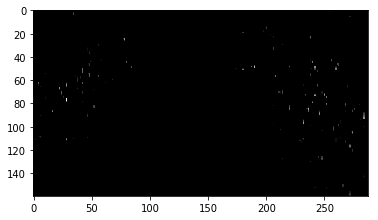

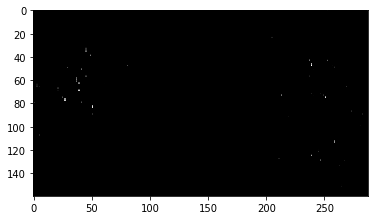

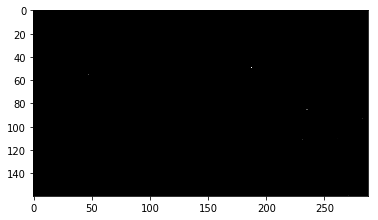

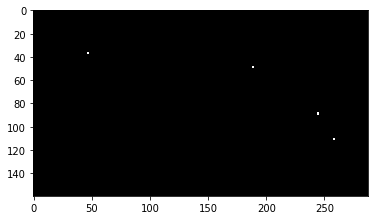

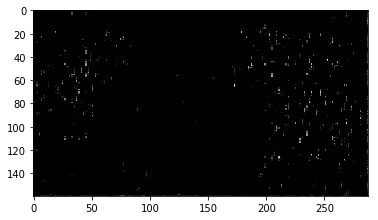

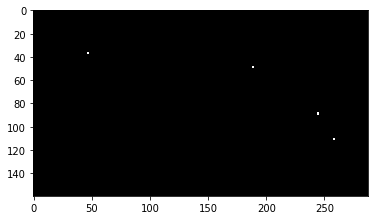

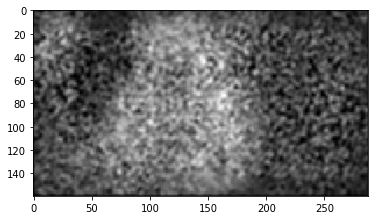

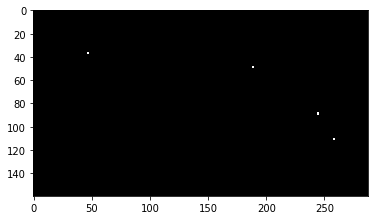

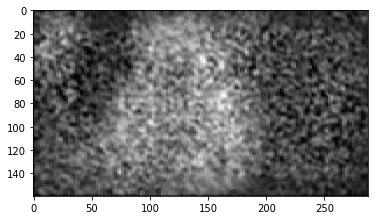

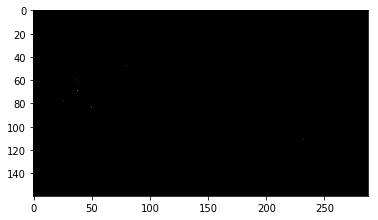

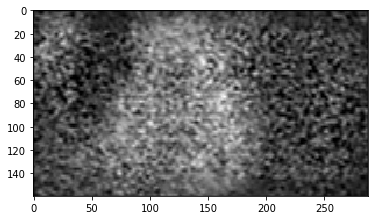

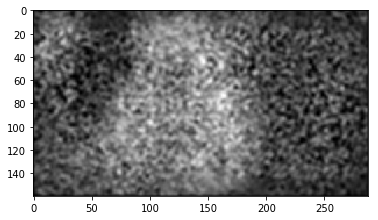

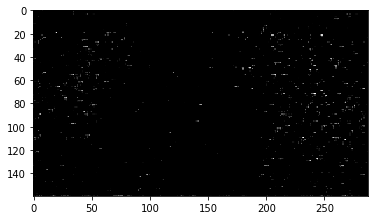

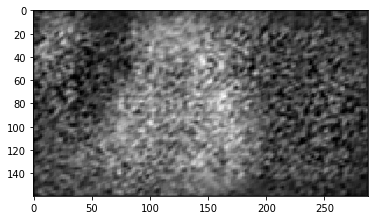

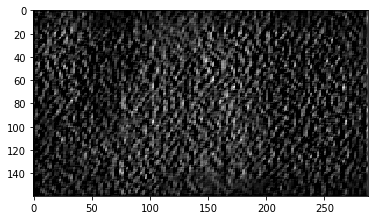

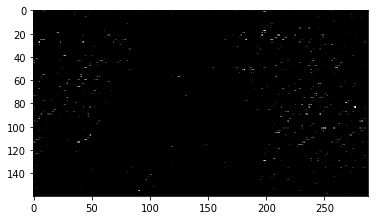

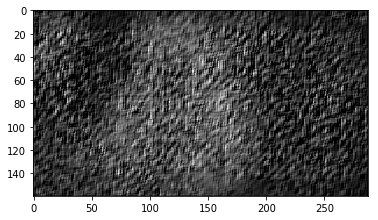

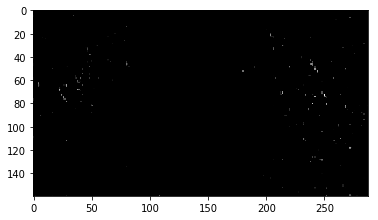

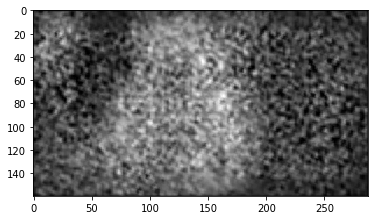

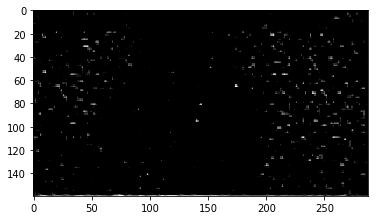

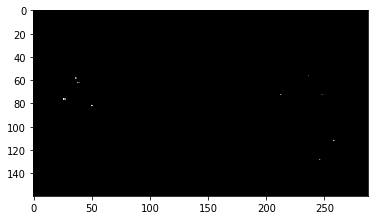

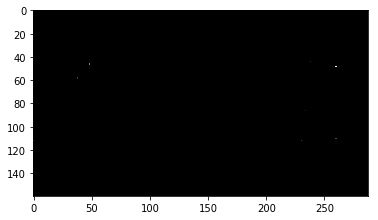

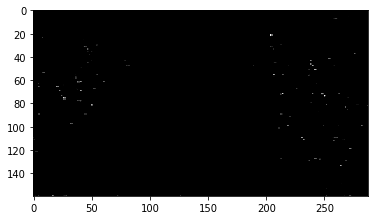

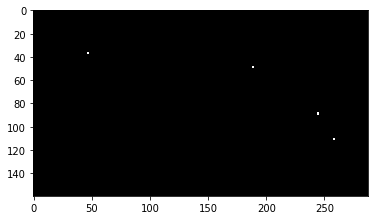

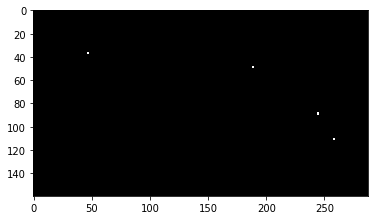

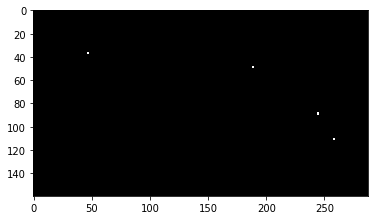

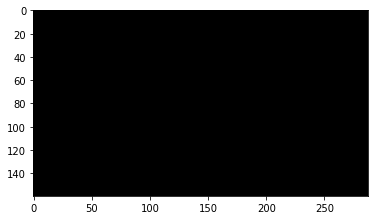

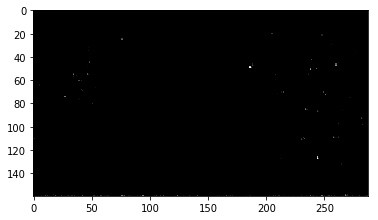

In [42]:
for layer in range(0,33):
    plt.imshow(up_conv[0,:,:,layer],cmap="gray", vmin= 0, vmax=up_conv[0,:,:,layer].max())
    plt.show()